## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER Configuration #
######################
A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 

x,u = gen_traindata(1001)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_test = np.concatenate((x_test, spatial_domain.random_points(n_test)))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)
# bc135 = dde.PointSetBC(observe_x, observe_y)

# x[0] = R, x[1] = Z, u[0] = U
bc2 = dde.OperatorBC(spatial_domain ,
                    lambda x, u, _: psi_zz(x, u)+ N1*psi_r(x,u), 
                    boundary_outer)

bc4 = dde.OperatorBC(spatial_domain,
                    lambda x, u, _: psi_zz(x, u)+ N2*psi_r(x,u), 
                    boundary_inner)

bc6 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_high)
bc7 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_rr(x, u)+ N3 * psi_z(x, u), boundary_high)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    #anchors=observe_x,
    num_domain=1024,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="Hammersley"
)

net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


TypeError: __init__() got an unexpected keyword argument 'x_test'

Text(0, 0.5, '$u(r,z=0)$')

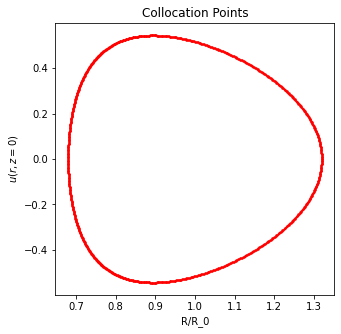

In [2]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [3]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)


## Train Model

Compiling model...
Building feed-forward neural network...


/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'build' took 0.258242 s

'compile' took 1.956814 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.10e+00, 3.80e-01]    [1.16e+00, 0.00e+00]    []  
1         [1.38e+00, 4.67e+00]    [1.43e+00, 0.00e+00]    []  
2         [1.19e+00, 5.47e-01]    [1.24e+00, 0.00e+00]    []  
3         [1.04e+00, 3.06e-01]    [1.09e+00, 0.00e+00]    []  
4         [9.66e-01, 1.23e+00]    [1.02e+00, 0.00e+00]    []  
5         [9.60e-01, 9.25e-01]    [1.01e+00, 0.00e+00]    []  
6         [9.89e-01, 2.46e-01]    [1.04e+00, 0.00e+00]    []  
7         [1.03e+00, 8.47e-02]    [1.08e+00, 0.00e+00]    []  
8         [1.07e+00, 3.88e-01]    [1.12e+00, 0.00e+00]    []  
9         [1.08e+00, 4.79e-01]    [1.13e+00, 0.00e+00]    []  
10        [1.08e+00, 2.63e-01]    [1.13e+00, 0.00e+00]    []  
11        [1.06e+00, 5.04e-02]    [1.11e+00, 0.00e+00]    []  
12        [1.04e+00, 5.71e-03]    [1.09e+00, 0.00e+00]    []  
13        [1.0

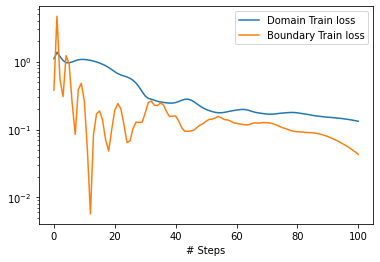

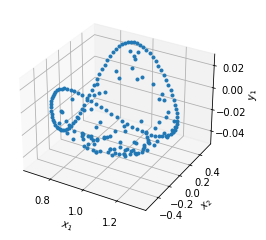

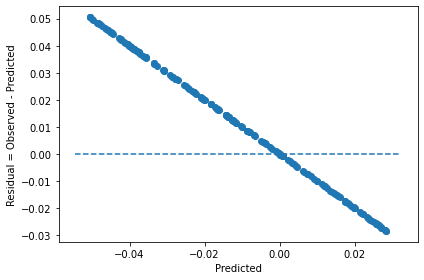

Accuracy
Mean residual: 0.399986


In [4]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 20
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 1)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

## Plotting

#### Before BFGS

Average normalized percent error on midplane =  48.98672812255118
Max normalized percent error on midplane =  107.87930757377873
(501, 501)
Average normalized percent error =  33.38839217977673
Max normalized percent error =  101.53328549217937


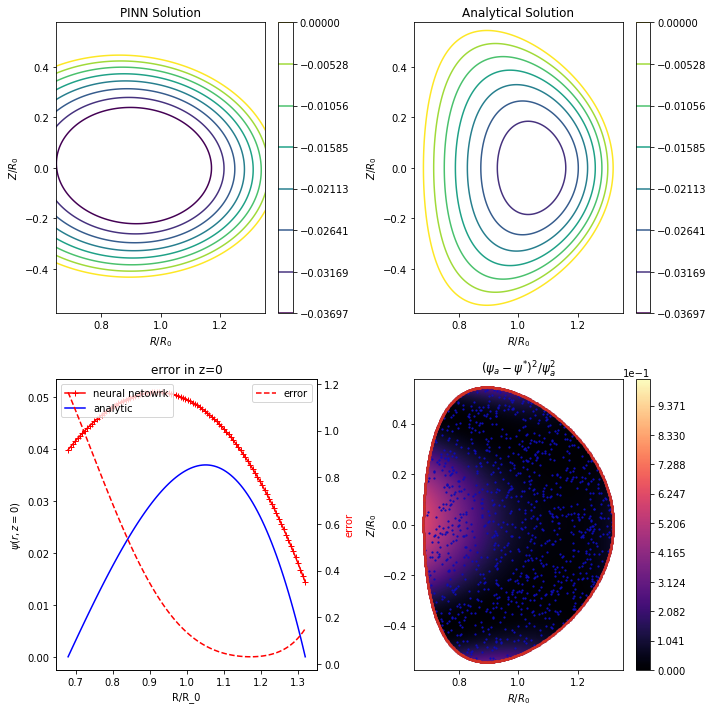

In [5]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
ITER = GS_Linear(eps= 0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
x,y,psi_pred,psi_true,error=evaluate(ITER,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(ITER,model)
X_test = spatial_domain.random_points(333)


#### After BFGS

Compiling model...
'compile' took 2.935962 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.32e-01, 4.31e-02]    [1.92e-01, 0.00e+00]    []  
110       [8.21e-02, 2.10e-02]                                
120       [2.35e-03, 1.47e-02]                                
130       [3.18e-03, 3.81e-03]                                
140       [5.45e-04, 1.44e-03]                                
150       [3.70e-04, 1.31e-03]                                
160       [2.48e-04, 1.16e-03]                                
170       [3.20e-04, 6.94e-04]                                
180       [3.70e-04, 3.42e-04]                                
190       [4.19e-04, 1.90e-04]                                
200       [4.60e-04, 1.41e-04]                                
210       [2.06e-04, 1.20e-04]                                
220       [5.71e-05, 1.63e-05]                                
230       [5.14e-05, 1.06e-05]                

1380      [3.24e-07, 7.41e-08]                                
1390      [3.04e-07, 8.47e-08]                                
1400      [3.03e-07, 8.40e-08]                                
1410      [3.05e-07, 7.76e-08]                                
1420      [3.11e-07, 6.79e-08]                                
1430      [3.10e-07, 6.61e-08]                                
1440      [3.12e-07, 6.31e-08]                                
1450      [3.13e-07, 6.16e-08]                                
1460      [3.14e-07, 6.03e-08]                                
1470      [3.13e-07, 5.95e-08]                                
1480      [3.14e-07, 5.91e-08]                                
1490      [3.14e-07, 5.90e-08]                                
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 1155
  Number of functions evaluations: 1399
1499      [3.14e-07, 5.90e-08]   

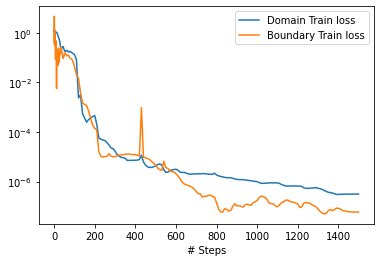

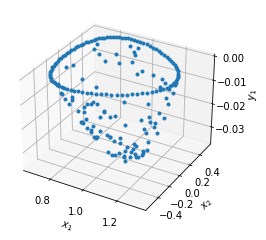

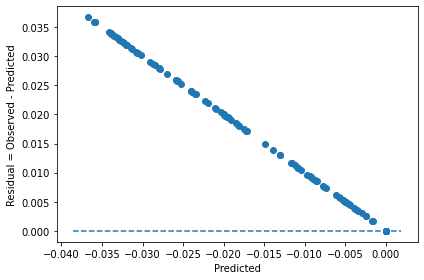

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


Average normalized percent error on midplane =  0.01821826598068461
Max normalized percent error on midplane =  0.08254525877206749
(501, 501)
Average normalized percent error =  0.02317904323508186
Max normalized percent error =  0.11881043447010105


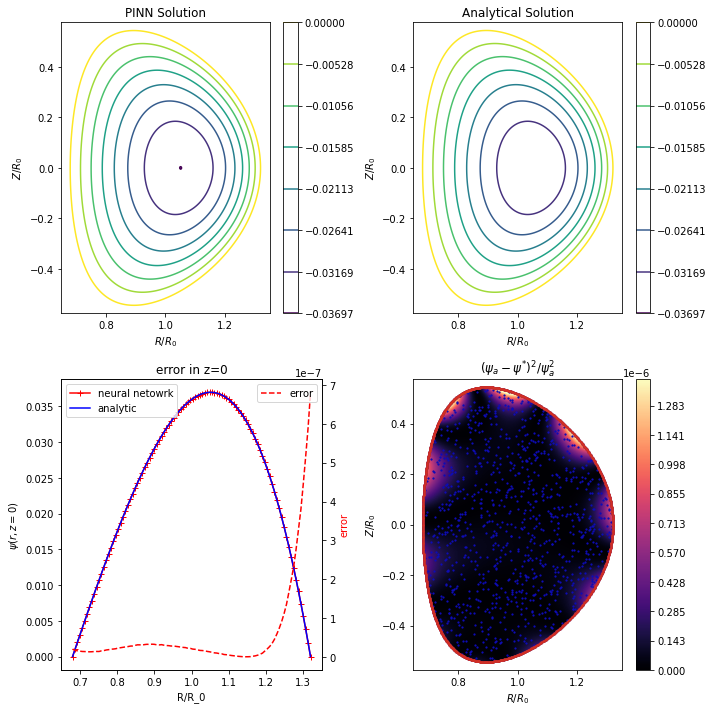

In [7]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
x,y,psi_pred,psi_true,error=evaluate(ITER,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(ITER,model)
X_test = spatial_domain.random_points(333)

# Plotting Setup
print(psi_pred.shape)
fig,axs=plt.subplots(2,2,figsize=(10,10))
ax1,ax2,ax3,ax4=axs[0][0],axs[0][1],axs[1][0],axs[1][1]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,levels=levels)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,levels=levels)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,ITER,X_test=X_test)
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS.jpg')



